# Fast NODD GRIB Aggregations

## Overview

In this tutorial we are going to demonstrate building fast kerchunk aggregations of NODD grib2 weather forecasts. This workflow primarily involves [xarray-datatree](https://xarray-datatree.readthedocs.io/en/latest/), [pandas](https://pandas.pydata.org/) and the new `grib_tree` function released in kerchunk v0.2.3.


### About the Dataset

In this demo we will be looking at GRIB2 files generated by [**NOAA Global Ensemble Forecast System (GEFS)**](https://www.ncei.noaa.gov/products/weather-climate-models/global-ensemble-forecast). This dataset is a weather forecast model made up of 21 separate forecasts, or ensemble members. GEFS has global coverage and is produced four times a day with forecasts going out to 16 days. It is updated 4 times a day, every 6 hours starting at midnight.

More information on this dataset can be found [here](https://registry.opendata.aws/noaa-gefs)


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Kerchunk Basics](../foundations/kerchunk_basics) | Required | Core |
| [Pandas Tutorial](https://foundations.projectpythia.org/core/pandas/pandas.html#) | Required | Core |
| [Kerchunk and Xarray-Datatree](https://projectpythia.org/kerchunk-cookbook/notebooks/using_references/Datatree.html) | Required | IO |
| [Xarray-Datatree Overview](https://xarray-datatree.readthedocs.io/en/latest/quick-overview.html)| Required | IO |

- **Time to learn**: 30 minutes

## Motivation

As we know that **kerchunk**  provides a unified way to represent a variety of chunked, compressed data formats (e.g. NetCDF/HDF5, GRIB2, TIFF, …) by generating *references*. This task flow has ability to build large aggregations from **NODD grib forecasts**
in a fraction of the time using the `idx files`.

## Imports

In [2]:

import logging
import importlib
importlib.reload(logging)
logging.basicConfig(
    format="%(asctime)s.%(msecs)03dZ %(processName)s %(threadName)s %(levelname)s:%(name)s:%(message)s",
    datefmt="%Y-%m-%dT%H:%M:%S",
    level=logging.WARNING,
)

logger = logging.getLogger("juypter")


import copy
import fsspec
import pandas as pd
import xarray as xr
import datetime
from kerchunk.grib2 import (
    AggregationType,
    build_idx_grib_mapping,
    extract_datatree_chunk_index,
    grib_tree,
    map_from_index,
    parse_grib_idx,
    reinflate_grib_store,
    scan_grib,
    strip_datavar_chunks,
)

## Building the Aggregation directly from the GRIB files

We are using the newly implemented Kerchunk `grib_tree` function to build a hierarchical data model from a set of scanned grib messages.This data model can be opened directly using either zarr or xarray datatree. *This way of building the aggregation is very slow*. Here we're going to use xarray-datatree to open and view it:

In [3]:
s3_files = [
    "s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af006",
    "s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af012",
    "s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af018",
    "s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af024",
    "s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af030",
    "s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af036",
    "s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af042",
]

In [3]:
# converting the references into the hierarchical datamodel
grib_tree_store = grib_tree(
    [
        group
        for f in s3_files
        for group in scan_grib(f, storage_options=dict(anon=True))
    ],
    remote_options=dict(anon=True),
)

/home/rsignell/miniforge3/envs/grib-idx/lib/python3.13/site-packages/kerchunk/combine.py:376: UserWarning: Concatenated coordinate 'time' contains less than expectednumber of values across the datasets: [1483250400]
  warnings.warn(


In [4]:
# Transforming the output to datatree to view it. This tree model the variables
s3_dt = xr.open_datatree(
    fsspec.filesystem(
        "reference",
        fo=grib_tree_store,
        remote_protocol="s3",
        remote_options={"anon": True},
    ).get_mapper(""),
    engine="zarr",
    consolidated=False,
)

In [5]:
# In this tree model, the variables are organized into hierarchical groups, first by "stepType" and then by "typeOfLevel."
s3_dt

<xarray.DataTree>
Group: /
├── Group: /cape
│   │   Attributes:
│   │       name:     Convective available potential energy
│   └── Group: /cape/instant
│       │   Attributes:
│       │       stepType:  instant
│       └── Group: /cape/instant/pressureFromGroundLayer
│               Dimensions:     (time: 1, step: 7, latitude: 181, longitude: 360)
│               Coordinates:
│                 * latitude    (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
│                 * longitude   (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
│                   number      (time, step) int64 56B ...
│                 * step        (step) timedelta64[ns] 56B 0 days 06:00:00 ... 1 days 18:00:00
│                 * time        (time) datetime64[ns] 8B 2017-01-01T06:00:00
│                   valid_time  (time, step) datetime64[ns] 56B ...
│               Data variables:
│                   cape        (time, step, latitude, longitude) float64 4MB ...
│               Attributes:
│                   typeOfLevel:  pressureFromGroundLayer
├── Group: /cfrzr
│   │   Attributes:
│   │       name:     Categorical freezing rain
│   └── Group: /cfrzr/avg
│       │   Attributes:
│       │       stepType:  avg
│       └── Group: /cfrzr/avg/surface
│               Dimensions:     (time: 1, step: 7, latitude: 181, longitude: 360)
│               Coordinates:
│                 * latitude    (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
│                 * longitude   (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
│                   number      (time, step) int64 56B ...
│                 * step        (step) timedelta64[ns] 56B 0 days 06:00:00 ... 1 days 18:00:00
│                   surface     float64 8B ...
│                 * time        (time) datetime64[ns] 8B 2017-01-01T06:00:00
│                   valid_time  (time, step) datetime64[ns] 56B ...
│               Data variables:
│                   cfrzr       (time, step, latitude, longitude) float64 4MB ...
│               Attributes:
│                   typeOfLevel:  surface
├── Group: /cicep
│   │   Attributes:
│   │       name:     Categorical ice pellets
│   └── Group: /cicep/avg
│       │   Attributes:
│       │       stepType:  avg
│       └── Group: /cicep/avg/surface
│               Dimensions:     (time: 1, step: 7, latitude: 181, longitude: 360)
│               Coordinates:
│                 * latitude    (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
│                 * longitude   (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
│                   number      (time, step) int64 56B ...
│                 * step        (step) timedelta64[ns] 56B 0 days 06:00:00 ... 1 days 18:00:00
│                   surface     float64 8B ...
│                 * time        (time) datetime64[ns] 8B 2017-01-01T06:00:00
│                   valid_time  (time, step) datetime64[ns] 56B ...
│               Data variables:
│                   cicep       (time, step, latitude, longitude) float64 4MB ...
│               Attributes:
│                   typeOfLevel:  surface
├── Group: /cin
│   │   Attributes:
│   │       name:     Convective inhibition
│   └── Group: /cin/instant
│       │   Attributes:
│       │       stepType:  instant
│       └── Group: /cin/instant/pressureFromGroundLayer
│               Dimensions:     (time: 1, step: 7, latitude: 181, longitude: 360)
│               Coordinates:
│                 * latitude    (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
│                 * longitude   (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
│                   number      (time, step) int64 56B ...
│                 * step        (step) timedelta64[ns] 56B 0 days 06:00:00 ... 1 days 18:00:00
│                 * time        (time) datetime64[ns] 8B 2017-01-01T06:00:00
│                   valid_time  (time, step) datetime64[ns] 56B ...
│               Data variables:
│ 

> **Note**: If trying out this notebook, the above way of building the aggregation will take few minutes for this `GEFS` S3 repository. But in general, it take more time, based on the size of the grib files

## Building the aggregation faster with `idx` files

This method of aggregating GRIB files requires that each GRIB file be accompanied by its corresponding `idx` file in text format. This file, also called index files, contain some key metadata of the GRIB messages across the files. These metadata is then used to build an reference index, which helps in aggregation. 

The advantage is, building aggregation this way doesn't involve scanning the whole archive of GRIB files but only a single file. 

### Index Dataframe made from a single Grib file

Here is what the contents of an `idx` file looks like.

```
1:0:d=2017010100:HGT:10 mb:12 hour fcst:ENS=low-res ctl
2:48163:d=2017010100:TMP:10 mb:12 hour fcst:ENS=low-res ctl
3:68112:d=2017010100:RH:10 mb:12 hour fcst:ENS=low-res ctl
4:79092:d=2017010100:UGRD:10 mb:12 hour fcst:ENS=low-res ctl
5:102125:d=2017010100:VGRD:10 mb:12 hour fcst:ENS=low-res ctl
6:122799:d=2017010100:HGT:50 mb:12 hour fcst:ENS=low-res ctl
7:178898:d=2017010100:TMP:50 mb:12 hour fcst:ENS=low-res ctl
8:201799:d=2017010100:RH:50 mb:12 hour fcst:ENS=low-res ctl
9:224321:d=2017010100:UGRD:50 mb:12 hour fcst:ENS=low-res ctl
10:272234:d=2017010100:VGRD:50 mb:12 hour fcst:ENS=low-res ctl
11:318288:d=2017010100:HGT:100 mb:12 hour fcst:ENS=low-res ctl
12:379010:d=2017010100:TMP:100 mb:12 hour fcst:ENS=low-res ctl
13:405537:d=2017010100:RH:100 mb:12 hour fcst:ENS=low-res ctl
14:441517:d=2017010100:UGRD:100 mb:12 hour fcst:ENS=low-res ctl
15:497421:d=2017010100:VGRD:100 mb:12 hour fcst:ENS=low-res ctl
```

The general format of `idx` data is: **index:offset:date_with_runtime:variable:forecast_time:**.

The metadata are separated by ":" (colon) and we need to convert it into a `Dataframe` for building the index. 


> **Note**: This way of building the reference index only works for a particular **horizon** file irrespective of the run time of the model, as the  messages from a same time horizon have an identical structure

In [23]:
# converting the idx data into a dataframe
idxdf = parse_grib_idx(
    #"s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af006",
    "s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb2sp25/geavg.t00z.pgrb2s.0p25.f006",
    storage_options=dict(anon=True),
    
)
idxdf.head()

,offset,date,attrs,length,idx_uri,grib_uri
idx,,,,,,
1,0,d=2023010100,VIS:surface:6 hour fcst:ens mean,447087,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...
2,447087,d=2023010100,GUST:surface:6 hour fcst:ens mean,470955,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...
3,918042,d=2023010100,MSLET:mean sea level:6 hour fcst:ens mean,860511,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...
4,1778553,d=2023010100,PRES:surface:6 hour fcst:ens mean,741916,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...
5,2520469,d=2023010100,TSOIL:0-0.1 m below ground:6 hour fcst:ens mean,377669,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...


### Building a mapping between the index data and grib metadata

Creation of the reference index or **k_index** first involves generating a single mapping from the grib/zarr metadata(the `grib_tree` output) to the attributes in the idx files. They are unique for each time horizon, so while building the index, we need to build a unique mapping for the 1 hour forecast, the 2 hour forecast and so on. 

This mapping can be made from any arbitrary GRIB file, given that the it belongs to the **same time horizon** of files we're trying to index. 

We'll start by examining the GRIB data. The metadata that we'll be extracting will be static in nature. We're going to use a single node by [accessing](https://projectpythia.org/kerchunk-cookbook/notebooks/using_references/Datatree.html#accessing-the-datatree) it with datatree.

In [5]:
s3_dt.groups

NameError: name 's3_dt' is not defined

In [8]:
# Parsing the grib metadata from a single datatree node and converting it into a dataframe
grib_df = extract_datatree_chunk_index(s3_dt["sulwrf/avg/nominalTop"], grib_tree_store)
grib_df.head()

,varname,typeOfLevel,stepType,name,nominalTop,number,step,time,valid_time,uri,offset,length,inline_value
0,sulwrf,nominalTop,avg,Surface upward long-wave radiation flux,0.0,0,0 days 06:00:00,2017-01-01 06:00:00,2017-01-01 12:00:00,s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z...,3924345,43221,None
1,sulwrf,nominalTop,avg,Surface upward long-wave radiation flux,0.0,0,0 days 12:00:00,2017-01-01 06:00:00,2017-01-01 18:00:00,s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z...,3951119,42550,None
2,sulwrf,nominalTop,avg,Surface upward long-wave radiation flux,0.0,0,0 days 18:00:00,2017-01-01 06:00:00,2017-01-02 00:00:00,s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z...,3948238,43273,None
3,sulwrf,nominalTop,avg,Surface upward long-wave radiation flux,0.0,0,1 days 00:00:00,2017-01-01 06:00:00,2017-01-02 06:00:00,s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z...,3876964,42613,None
4,sulwrf,nominalTop,avg,Surface upward long-wave radiation flux,0.0,0,1 days 06:00:00,2017-01-01 06:00:00,2017-01-02 12:00:00,s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z...,3865989,42782,None


> **Note**: Above process is part of the mapping creation, the function call to `extract_datatree_chunk_index` in handled inside `build_idx_grib_mapping` function

In [18]:
# creating a mapping for a single horizon file which is to be used later
mapping = build_idx_grib_mapping(
    #"s3://noaa-gefs-pds/gefs.20170101/00/geavg00.t00z.pgrb2f006",
    "s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb2sp25/geavg.t00z.pgrb2s.0p25.f006",
    storage_options=dict(anon=True),
    validate=True,
)
mapping.head()

,offset_idx,date,attrs,length_idx,idx_uri,grib_uri,varname,typeOfLevel,stepType,name,step,level,time,valid_time,uri,offset_grib,length_grib,inline_value
idx,,,,,,,,,,,,,,,,,,
1,0,d=2023010100,VIS:surface:6 hour fcst:ens mean,447087,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,vis,surface,instant,Visibility,0 days 06:00:00,0.0,2023-01-01,2023-01-01 06:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,0,447087,None
2,447087,d=2023010100,GUST:surface:6 hour fcst:ens mean,470955,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,gust,surface,instant,Wind speed (gust),0 days 06:00:00,0.0,2023-01-01,2023-01-01 06:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,447087,470955,None
3,918042,d=2023010100,MSLET:mean sea level:6 hour fcst:ens mean,860511,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,mslet,meanSea,instant,MSLP (Eta model reduction),0 days 06:00:00,0.0,2023-01-01,2023-01-01 06:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,918042,860511,None
4,1778553,d=2023010100,PRES:surface:6 hour fcst:ens mean,741916,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,sp,surface,instant,Surface pressure,0 days 06:00:00,0.0,2023-01-01,2023-01-01 06:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,1778553,741916,None
5,2520469,d=2023010100,TSOIL:0-0.1 m below ground:6 hour fcst:ens mean,377669,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,st,depthBelowLandLayer,instant,Soil temperature,0 days 06:00:00,NaN,2023-01-01,2023-01-01 06:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,2520469,377669,None


>**Note**: Reference index can be combined across many horizons but **each horizon must be indexed separately**.

### Building the index 

Now if we parse the runtime from the idx file and other attributes, we can build a fully compatible kerchunk index(k_index) for that 
**particular file**. Before creating the index, we need to clean some of the data in the mapping and index dataframe for the some variables as they tend to contain duplicate values, as demonstrated below. 

In [21]:
# cleaning the mapping
mapping.loc[mapping["attrs"].duplicated(keep=False), :]

,offset_idx,date,attrs,length_idx,idx_uri,grib_uri,varname,typeOfLevel,stepType,name,step,level,time,valid_time,uri,offset_grib,length_grib,inline_value
idx,,,,,,,,,,,,,,,,,,


In [24]:
# this step will be performed for every idx dataframe where we will be using the "mapping" dataframe which we created previously
mapped_index = map_from_index(
    pd.Timestamp("2017-01-01T06"),
    mapping.loc[~mapping["attrs"].duplicated(keep="first"), :],
    idxdf.loc[~idxdf["attrs"].duplicated(keep="first"), :],
)
mapped_index.head()

,varname,typeOfLevel,stepType,name,step,level,time,valid_time,uri,offset,length,inline_value
0,vis,surface,instant,Visibility,0 days 06:00:00,0.0,2017-01-01 06:00:00,2017-01-01 12:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,0,447087,None
1,gust,surface,instant,Wind speed (gust),0 days 06:00:00,0.0,2017-01-01 06:00:00,2017-01-01 12:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,447087,470955,None
2,mslet,meanSea,instant,MSLP (Eta model reduction),0 days 06:00:00,0.0,2017-01-01 06:00:00,2017-01-01 12:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,918042,860511,None
3,sp,surface,instant,Surface pressure,0 days 06:00:00,0.0,2017-01-01 06:00:00,2017-01-01 12:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,1778553,741916,None
4,st,depthBelowLandLayer,instant,Soil temperature,0 days 06:00:00,NaN,2017-01-01 06:00:00,2017-01-01 12:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,2520469,377669,None


### Final step of building of Aggregation

For the final step of the aggregation, we will create an index for each GRIB file to cover a two-month period. We will be using the 6-hour horizon file for building the aggregation, this will be from `2017-01-01` to `2017-02-28`. The generated index can then be combined with indexes of other time horizons and stored for later use. 

In [50]:
%%time
mapped_index_list = []

deduped_mapping = mapping.loc[~mapping["attrs"].duplicated(keep="first"), :]

# this process is manually done because the runtime and forecast time will vary between models i.e. GEFS, GFS, HRRR etc.
for date in pd.date_range("2023-01-01", "2023-02-28"):
    for runtime in range(0, 24, 6):
        #fname = f"s3://noaa-gefs-pds/gefs.{date.strftime('%Y%m%d')}/{runtime:02}/gec00.t{runtime:02}z.pgrb2af006"
        fname = f"s3://noaa-gefs-pds/gefs.{date.strftime('%Y%m%d')}/{runtime:02}/atmos/pgrb2sp25/geavg.t{runtime:02}z.pgrb2s.0p25.f006"

        idxdf = parse_grib_idx(basename=fname, storage_options=dict(anon=True))
    
        mapped_index = map_from_index(
            pd.Timestamp(date + datetime.timedelta(hours=runtime)),
            deduped_mapping,
            idxdf.loc[~idxdf["attrs"].duplicated(keep="first"), :],
        )
    
        mapped_index_list.append(mapped_index)

s3_kind = pd.concat(mapped_index_list)

CPU times: user 5.23 s, sys: 369 ms, total: 5.6 s
Wall time: 42.4 s


> **Tip**: To confirm the above step, check out this [notebook](https://gist.github.com/Anu-Ra-g/efa01ad1c274c1bd1c14ee01666caa77)

## Using the aggregation

The difference between .idx and Kerchunk index that we built is that the former indexes the GRIB messages and the latter indexes the variables in those messages, in a time horizon. Now we'll need a tree model from grib_tree function to reinflate index (variables in the messages). The important point to note here is that the tree model should be made from the GRIB files of the repository that we are indexing.

In [27]:
grib_tree_store = grib_tree(
    scan_grib(
        #"s3://noaa-gefs-pds/gefs.20170101/06/gec00.t06z.pgrb2af006",
        "s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb2sp25/geavg.t00z.pgrb2s.0p25.f006",
        storage_options=dict(anon=True),
    ),
    remote_options=dict(anon=True),
)

/Users/dstuebe/bando/external/kerchunk/kerchunk/combine.py:376: UserWarning: Concatenated coordinate 'time' contains less than expectednumber of values across the datasets: [1672531200]
  warnings.warn(
/Users/dstuebe/bando/external/kerchunk/kerchunk/combine.py:376: UserWarning: Concatenated coordinate 'step' contains less than expectednumber of values across the datasets: [6]
  warnings.warn(


Then we need to run that tree model through `strip_datavar_chunks` function, which will strip the tree of the variables *in place*. This step is optional

In [28]:
deflated_s3_grib_tree_store = copy.deepcopy(
    grib_tree_store
)  # not affecting the original tree model
strip_datavar_chunks(deflated_s3_grib_tree_store)

After stripping the tree model, we need to introduce two new axes: the `runtime` used for mapping and `date_range` for indexing the new reinflated tree. 

In [51]:
axes = [
    pd.Index(
        [
            pd.timedelta_range(
                start="0 hours", end="6 hours", freq="6h", closed="right", name="6 hour"
            ),
        ],
        name="step",
    ),
    pd.date_range(
        "2023-01-01T00:00", "2023-02-28T18:00", freq="360min", name="valid_time"
    ),
]
axes

[Index([[0 days 06:00:00]], dtype='object', name='step'),
 DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 06:00:00',
                '2023-01-01 12:00:00', '2023-01-01 18:00:00',
                '2023-01-02 00:00:00', '2023-01-02 06:00:00',
                '2023-01-02 12:00:00', '2023-01-02 18:00:00',
                '2023-01-03 00:00:00', '2023-01-03 06:00:00',
                ...
                '2023-02-26 12:00:00', '2023-02-26 18:00:00',
                '2023-02-27 00:00:00', '2023-02-27 06:00:00',
                '2023-02-27 12:00:00', '2023-02-27 18:00:00',
                '2023-02-28 00:00:00', '2023-02-28 06:00:00',
                '2023-02-28 12:00:00', '2023-02-28 18:00:00'],
               dtype='datetime64[ns]', name='valid_time', length=236, freq='360min')]

In [52]:
s3_kind.loc[s3_kind.varname.isin(["sdswrf"])].head(20)

,varname,typeOfLevel,stepType,name,step,level,time,valid_time,uri,offset,length,inline_value
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-01 00:00:00,2023-01-01 06:00:00,s3://noaa-gefs-pds/gefs.20230101/00/atmos/pgrb...,14530614,213995,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-01 06:00:00,2023-01-01 12:00:00,s3://noaa-gefs-pds/gefs.20230101/06/atmos/pgrb...,14865814,211327,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-01 12:00:00,2023-01-01 18:00:00,s3://noaa-gefs-pds/gefs.20230101/12/atmos/pgrb...,15045092,214598,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-01 18:00:00,2023-01-02 00:00:00,s3://noaa-gefs-pds/gefs.20230101/18/atmos/pgrb...,14762792,263112,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-02 00:00:00,2023-01-02 06:00:00,s3://noaa-gefs-pds/gefs.20230102/00/atmos/pgrb...,14538351,213571,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-02 06:00:00,2023-01-02 12:00:00,s3://noaa-gefs-pds/gefs.20230102/06/atmos/pgrb...,14894734,212203,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-02 12:00:00,2023-01-02 18:00:00,s3://noaa-gefs-pds/gefs.20230102/12/atmos/pgrb...,14648698,220218,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-02 18:00:00,2023-01-03 00:00:00,s3://noaa-gefs-pds/gefs.20230102/18/atmos/pgrb...,14833794,392651,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-03 00:00:00,2023-01-03 06:00:00,s3://noaa-gefs-pds/gefs.20230103/00/atmos/pgrb...,14433760,214388,None
29,sdswrf,surface,avg,Surface downward short-wave radiation flux,0 days 06:00:00,0.0,2023-01-03 06:00:00,2023-01-03 12:00:00,s3://noaa-gefs-pds/gefs.20230103/06/atmos/pgrb...,14594147,213004,None


Now for reinflating, we'll be needing the aggregation types which are: `horizon`, `valid_time`, `run_time` and `best_available`. We will also be needing the variable(s) that we are reinflating. 

In [53]:
s3_store = reinflate_grib_store(
    axes=axes,
    aggregation_type=AggregationType.HORIZON,
    chunk_index=s3_kind.loc[s3_kind.varname.isin(["sulwrf", "prmsl", "sdswrf"])],
    zarr_ref_store=deflated_s3_grib_tree_store,
)

/Users/dstuebe/bando/external/kerchunk/kerchunk/_grib_idx.py:347: PerformanceWarning: indexing past lexsort depth may impact performance.
  if lookup not in unique_groups:


## Viewing the new subset of the datatree

In this step, we can view the new subset as a `datatree` model. 

In [54]:
s3_dt_subset = xr.open_datatree(
    fsspec.filesystem(
        "reference", fo=s3_store, remote_protocol="s3", remote_options={"anon": True}
    ).get_mapper(""),
    engine="zarr",
    consolidated=False,
)

In [55]:
s3_dt_subset

<xarray.DataTree>
Group: /
├── Group: /prmsl
│   │   Attributes:
│   │       name:     Pressure reduced to MSL
│   └── Group: /prmsl/instant
│       │   Attributes:
│       │       stepType:  instant
│       └── Group: /prmsl/instant/meanSea
│               Dimensions:     (latitude: 721, longitude: 1440, model_horizons: 1,
│                                valid_times: 236)
│               Coordinates:
│                 * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
│                   meanSea     float64 8B ...
│                   step        (model_horizons, valid_times) timedelta64[ns] 2kB ...
│                   time        (model_horizons, valid_times) datetime64[ns] 2kB ...
│                   valid_time  (model_horizons, valid_times) datetime64[ns] 2kB ...
│               Dimensions without coordinates: model_horizons, valid_times
│               Data variables:
│                   prmsl       (model_horizons, valid_times, latitude, longitude) float64 2GB ...
│               Attributes:
│                   typeOfLevel:  meanSea
├── Group: /sdswrf
│   │   Attributes:
│   │       name:     Surface downward short-wave radiation flux
│   └── Group: /sdswrf/avg
│       │   Attributes:
│       │       stepType:  avg
│       └── Group: /sdswrf/avg/surface
│               Dimensions:     (latitude: 721, longitude: 1440, model_horizons: 1,
│                                valid_times: 236)
│               Coordinates:
│                 * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
│                   step        (model_horizons, valid_times) timedelta64[ns] 2kB ...
│                   surface     float64 8B ...
│                   time        (model_horizons, valid_times) datetime64[ns] 2kB ...
│                   valid_time  (model_horizons, valid_times) datetime64[ns] 2kB ...
│               Dimensions without coordinates: model_horizons, valid_times
│               Data variables:
│                   sdswrf      (model_horizons, valid_times, latitude, longitude) float64 2GB ...
│               Attributes:
│                   typeOfLevel:  surface
└── Group: /sulwrf
    │   Attributes:
    │       name:     Surface upward long-wave radiation flux
    └── Group: /sulwrf/avg
        │   Attributes:
        │       stepType:  avg
        ├── Group: /sulwrf/avg/nominalTop
        │       Dimensions:     (latitude: 721, longitude: 1440, model_horizons: 1,
        │                        valid_times: 236)
        │       Coordinates:
        │         * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
        │         * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
        │           nominalTop  float64 8B ...
        │           step        (model_horizons, valid_times) timedelta64[ns] 2kB ...
        │           time        (model_horizons, valid_times) datetime64[ns] 2kB ...
        │           valid_time  (model_horizons, valid_times) datetime64[ns] 2kB ...
        │       Dimensions without coordinates: model_horizons, valid_times
        │       Data variables:
        │           sulwrf      (model_horizons, valid_times, latitude, longitude) float64 2GB ...
        │       Attributes:
        │           typeOfLevel:  nominalTop
        └── Group: /sulwrf/avg/surface
                Dimensions:     (latitude: 721, longitude: 1440, model_horizons: 1,
                                 valid_times: 236)
                Coordinates:
                  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
                  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
                    step        (model_horizons, valid_times) timedelta64[ns] 2kB ...
                    

In [56]:
s3_dt_subset.groups

('/',
 '/prmsl',
 '/sdswrf',
 '/sulwrf',
 '/prmsl/instant',
 '/sdswrf/avg',
 '/sulwrf/avg',
 '/prmsl/instant/meanSea',
 '/sdswrf/avg/surface',
 '/sulwrf/avg/nominalTop',
 '/sulwrf/avg/surface')

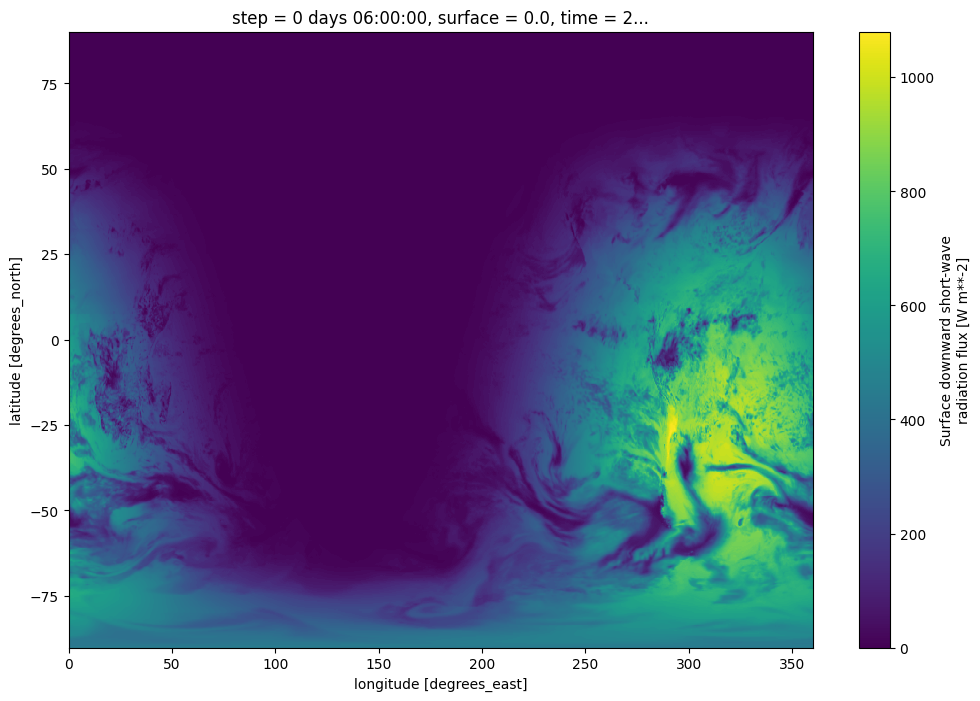

In [57]:
s3_dt_subset.sdswrf.avg.surface.sdswrf[0,3,:,:].plot(figsize=(12,8))

In [33]:
da = s3_dt_subset.sulwrf.avg.nominalTop.sulwrf.isel(model_horizons=0)
da

<xarray.DataArray 'sulwrf' (valid_times: 236, latitude: 721, longitude: 1440)> Size: 2GB
[245024640 values with dtype=float64]
Coordinates:
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    nominalTop  float64 8B ...
    step        (valid_times) timedelta64[ns] 2kB ...
    time        (valid_times) datetime64[ns] 2kB ...
    valid_time  (valid_times) datetime64[ns] 2kB ...
Dimensions without coordinates: valid_times
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sulwrf
    GRIB_dataType:                            pf
    ...                                       ...
    GRIB_typeOfLevel:                         nominalTop
    GRIB_units:                               W m**-2
    GRIB_uvRelativeToGrid:                    0
    long_name:                                Surface upward long-wave radiat...
    standard_name:                            unknown
    units:                                    W m**-2

#### Create an index for time

In [34]:
da= da.rename({'valid_times':'time'}).drop_vars(['step'])

/var/folders/cc/q6z3kw9j2kjgs3msh7368x7c0000gq/T/ipykernel_81271/309788138.py:1: UserWarning: rename 'valid_times' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da= da.rename({'valid_times':'time'}).drop_vars(['step'])


In [35]:
da = da.set_index(time='time')

In [36]:
da

<xarray.DataArray 'sulwrf' (time: 236, latitude: 721, longitude: 1440)> Size: 2GB
[245024640 values with dtype=float64]
Coordinates:
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    nominalTop  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-12-31T18:00:00 ... 2023-02-28T...
    valid_time  (time) datetime64[ns] 2kB ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sulwrf
    GRIB_dataType:                            pf
    ...                                       ...
    GRIB_typeOfLevel:                         nominalTop
    GRIB_units:                               W m**-2
    GRIB_uvRelativeToGrid:                    0
    long_name:                                Surface upward long-wave radiat...
    standard_name:                            unknown
    units:                                    W m**-2

In [37]:
da.sel(time='2023-01-02', method='nearest')

<xarray.DataArray 'sulwrf' (latitude: 721, longitude: 1440)> Size: 8MB
[1038240 values with dtype=float64]
Coordinates:
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    nominalTop  float64 8B ...
    time        datetime64[ns] 8B 2023-01-02
    valid_time  datetime64[ns] 8B ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sulwrf
    GRIB_dataType:                            pf
    ...                                       ...
    GRIB_typeOfLevel:                         nominalTop
    GRIB_units:                               W m**-2
    GRIB_uvRelativeToGrid:                    0
    long_name:                                Surface upward long-wave radiat...
    standard_name:                            unknown
    units:                                    W m**-2

#### Try extracting some data.  
The results from the cell below show lot's of NaN and what look like integer values. This doesn't seem like what would be expected for "Surface upward long-wave radiation flux", right?

In [38]:
%%time
da[:,90,180].load()

CPU times: user 731 ms, sys: 209 ms, total: 940 ms
Wall time: 3.13 s


<xarray.DataArray 'sulwrf' (time: 236)> Size: 2kB
array([ nan,  nan,  nan,  nan, 161.,  nan,  nan,  nan, 191.,  nan,  nan,
        nan, 175.,  nan,  nan,  nan, 182.,  nan,  nan,  nan, 188.,  nan,
        nan,  nan, 187.,  nan,  nan,  nan, 179.,  nan,  nan,  nan, 191.,
        nan,  nan,  nan, 155.,  nan,  nan,  nan, 195.,  nan,  nan,  nan,
       207.,  nan,  nan,  nan, 156.,  nan,  nan,  nan, 192.,  nan,  nan,
        nan, 183.,  nan,  nan,  nan, 194.,  nan,  nan,  nan, 155.,  nan,
        nan,  nan, 209.,  nan,  nan,  nan, 167.,  nan,  nan,  nan, 213.,
        nan,  nan,  nan, 176.,  nan,  nan,  nan, 213.,  nan,  nan,  nan,
       199.,  nan,  nan,  nan, 215.,  nan,  nan,  nan, 218.,  nan,  nan,
        nan, 205.,  nan,  nan,  nan, 208.,  nan,  nan,  nan, 192.,  nan,
        nan,  nan, 142.,  nan,  nan,  nan, 196.,  nan,  nan,  nan, 162.,
        nan,  nan,  nan, 188.,  nan,  nan,  nan, 204.,  nan,  nan,  nan,
       210.,  nan,  nan,  nan, 200.,  nan,  nan,  nan, 190.,  nan,  nan,
        nan, 199.,  nan,  nan,  nan, 198.,  nan,  nan,  nan, 165.,  nan,
        nan,  nan, 202.,  nan,  nan,  nan, 161.,  nan,  nan,  nan, 148.,
        nan,  nan,  nan, 214.,  nan,  nan,  nan, 158.,  nan,  nan,  nan,
       167.,  nan,  nan,  nan, 210.,  nan,  nan,  nan, 195.,  nan,  nan,
        nan, 215.,  nan,  nan,  nan, 217.,  nan,  nan,  nan, 161.,  nan,
        nan,  nan, 195.,  nan,  nan,  nan, 197.,  nan,  nan,  nan, 183.,
        nan,  nan,  nan, 203.,  nan,  nan,  nan, 200.,  nan,  nan,  nan,
       177.,  nan,  nan,  nan, 202.,  nan,  nan,  nan, 203.,  nan,  nan,
        nan, 170.,  nan,  nan,  nan])
Coordinates:
    latitude    float64 8B 67.5
    longitude   float64 8B 45.0
    nominalTop  float64 8B 0.0
  * time        (time) datetime64[ns] 2kB 2022-12-31T18:00:00 ... 2023-02-28T...
    valid_time  (time) datetime64[ns] 2kB 2023-01-01 ... 2023-02-28T18:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sulwrf
    GRIB_dataType:                            pf
    ...                                       ...
    GRIB_typeOfLevel:                         nominalTop
    GRIB_units:                               W m**-2
    GRIB_uvRelativeToGrid:                    0
    long_name:                                Surface upward long-wave radiat...
    standard_name:                            unknown
    units:                                    W m**-2